In [2]:
import torch
import yaml
from ml_collections import ConfigDict
from argparse import ArgumentParser
import os

from protein_ebm.model.r3_diffuser import R3Diffuser
from protein_ebm.data.protein_utils import residues_to_features, plot_protein_frame
from protein_ebm.model.ebm import ProteinEBM
from protein_ebm.model.boltz_utils import center_random_augmentation
import numpy as np



with open("../protein_ebm/config/base_pretrain.yaml", 'r') as f:
    config = yaml.safe_load(f)
    
config = ConfigDict(config)

# Create models
diffuser = R3Diffuser(config.diffuser)
model = ProteinEBM(config.model, diffuser).cuda()


# Load checkpoint
ckpt = torch.load("../weights/model_1_frozen_1m_md.pt", weights_only=False)



model.load_state_dict({k[len("model."):]: v for k, v in ckpt['state_dict'].items() if k.startswith('model')})

<All keys matched successfully>

In [3]:
import pandas as pd

lpla_dat = pd.read_csv('../eval_data/lpla.csv')
lpla_dat

,Mutant (WT Context),ESM IF Open Score,ESMIF Closed Score,Frame2Seq Open Score,Frame2Seq Closed Score,ThermoMPNN Open Score,ThermoMPNN Closed Score,ProteinMPNN Open Score,ProteinMPNN Closed Score,Sequence,Promiscuous Activity,Mutant Prediction
0,T57L,-4.122700,3.084173,-0.005920,0.018511,-0.285750,1.245727,-4.48540,6.70667,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.098,Closed
1,M332L,7.315878,4.022750,0.015717,0.015511,0.545752,0.256633,4.86090,4.89514,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.170,Neutral
2,N109A,1.473624,2.905642,0.004016,0.003829,0.353482,0.400815,3.35908,4.87427,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,NaN,NaN
3,Y11D,-0.140850,-0.799810,0.000552,0.003396,-1.198040,-0.119710,0.98994,4.86542,STLRLLISDSDDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.240,Neutral
4,W37Y,-7.667830,-7.810650,0.009623,0.010227,0.134662,0.113302,4.07228,4.81598,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLYRNADTVVIG...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6398,G73E,-13.695700,-17.156200,-0.024950,-0.041130,-1.110440,-2.621000,-5.83086,-12.98871,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,NaN,NaN
6399,P249R,-12.429900,-8.194070,-0.045270,-0.031370,-1.971780,-1.573370,-6.52944,-13.90543,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,NaN,NaN
6400,G73I,-20.698000,-21.951200,-0.030240,-0.045940,-1.885030,-2.329080,-4.81118,-14.17826,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,NaN,NaN
6401,L5D,-14.197600,-14.417000,-0.024490,-0.026380,-3.256450,-3.213290,-15.22387,-14.65346,STLRDLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,NaN,NaN


In [4]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa

parser = PDBParser(QUIET=True)

open_lpla = '../eval_data/confbiasing/3a7r.pdb'
closed_lpla = '../eval_data/confbiasing/1x2g.pdb'

structs = []
t = 0.10
for pdb_path in [open_lpla, closed_lpla]:
    structure = parser.get_structure("my_structure", pdb_path) 
    chain = list(structure.get_chains())[0]
    atom_positions, atom_mask, aatype, residue_idx = residues_to_features([r for r in chain.get_residues() if is_aa(r)])
    nres = atom_positions.shape[0]
    
    bsize=16
    ca_coords = center_random_augmentation(atom_positions[...,1,:].unsqueeze(0).expand([bsize,-1,-1]), torch.ones([bsize, nres])).view([bsize,-1,3])

    single_feats = {
        'r_noisy': ca_coords.cuda(),
        'aatype': aatype.unsqueeze(0).expand([bsize,-1]).cuda(),
        'mask': torch.ones([bsize, nres]).cuda(),
        'residue_idx': residue_idx.unsqueeze(0).expand([bsize,-1]).cuda(),
        't': torch.tensor([t]*bsize, dtype=torch.float).cuda(),
        'selfcond_coords' : ca_coords.cuda(),
    }
    
    structs.append(single_feats)
    

/orcd/home/002/jamesron/solab/ProteinEBM-cleanup/protein_ebm/data/protein_utils.py:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  atom_positions = torch.tensor(atom_positions, dtype=torch.float32)


In [5]:
from protein_ebm.data.protein_utils import restypes, restype_order

open_nrg = []
closed_nrg = []
native_nrgs = []

for i,r in lpla_dat.iterrows():
    mut = r['Mutant (WT Context)']
    aa1 = mut[0]
    aa2 = mut[-1]
    idx = int(mut[1:-1])

    nrgs = []

    for input_feats in structs:
        aatype_mut = input_feats['aatype'].clone()

        if not torch.any(input_feats['residue_idx'] == idx):
            nrgs.append(float('nan'))
            print("Index not present in one or more structures!")
            continue
            
        
        seq_idx = (input_feats['residue_idx'] == idx).nonzero()[0,-1]

        assert restypes[aatype_mut[0,seq_idx]] == aa1

        aatype_mut[:,seq_idx] = restype_order[aa2]

            
        mut_feats = {**input_feats, 'aatype' : aatype_mut} #.expand([2, -1]).cuda()}

        with torch.no_grad():
            out = model.compute_energy(mut_feats)
            
        nrgs.append(out['energy'].mean().item())

    # minus so higher is better
    open_nrg.append(nrgs[0])
    closed_nrg.append(nrgs[1])

    print(f"Row {i} Open {open_nrg[-1]}, Closed {closed_nrg[-1]}")

    

Row 0 Open 10006.791015625, Closed 9881.1826171875
Row 1 Open 10002.9873046875, Closed 9877.31640625
Row 2 Open 10018.451171875, Closed 9895.935546875
Row 3 Open 10000.990234375, Closed 9879.189453125
Row 4 Open 10003.025390625, Closed 9881.6337890625
Row 5 Open 10008.5576171875, Closed 9884.826171875
Row 6 Open 10008.3984375, Closed 9878.912109375
Row 7 Open 10017.2265625, Closed 9894.08203125
Row 8 Open 10001.841796875, Closed 9884.1875
Row 9 Open 10009.171875, Closed 9876.275390625
Row 10 Open 10009.716796875, Closed 9883.34765625
Row 11 Open 10017.6669921875, Closed 9894.771484375
Row 12 Open 10001.9599609375, Closed 9882.044921875
Row 13 Open 10012.552734375, Closed 9884.763671875
Row 14 Open 10014.955078125, Closed 9891.02734375
Row 15 Open 10006.74609375, Closed 9883.6845703125
Row 16 Open 10020.4580078125, Closed 9896.40234375
Row 17 Open 10006.0478515625, Closed 9885.177734375
Row 18 Open 10005.79296875, Closed 9882.0302734375
Row 19 Open 10017.8056640625, Closed 9895.67089843

KeyboardInterrupt: 

In [5]:
lpla_dat["ProteinEBM Open Energy"] = open_nrg
lpla_dat["ProteinEBM Closed Energy"] = closed_nrg
print(lpla_dat)

lpla_dat.to_csv("confbias_lpla_model_1.csv", index=False)

     Mutant (WT Context)  ESM IF Open Score  ESMIF Closed Score  \
0                   T57L          -4.122700            3.084173   
1                  M332L           7.315878            4.022750   
2                  N109A           1.473624            2.905642   
3                   Y11D          -0.140850           -0.799810   
4                   W37Y          -7.667830           -7.810650   
...                  ...                ...                 ...   
6398                G73E         -13.695700          -17.156200   
6399               P249R         -12.429900           -8.194070   
6400                G73I         -20.698000          -21.951200   
6401                 L5D         -14.197600          -14.417000   
6402                G73L         -18.661600          -19.324100   

      Frame2Seq Open Score  Frame2Seq Closed Score  ThermoMPNN Open Score  \
0                -0.005920                0.018511              -0.285750   
1                 0.015717               

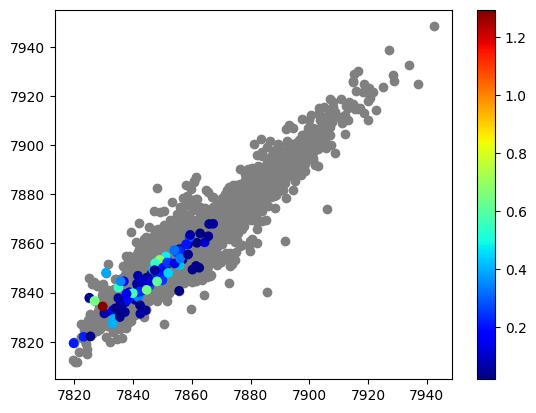

In [6]:
import matplotlib.pyplot as plt
plt.scatter(open_nrg, closed_nrg, color='grey')
plt.scatter(open_nrg, closed_nrg, c=lpla_dat['Promiscuous Activity'], cmap='jet')
plt.colorbar()

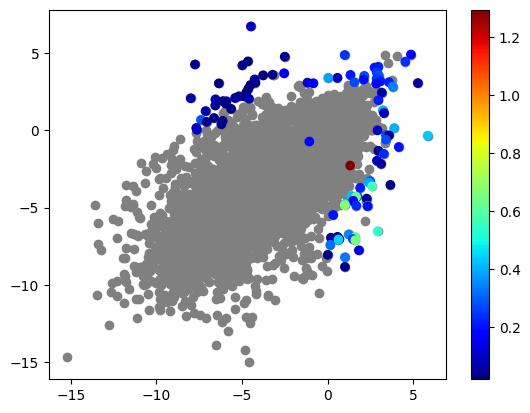

In [7]:
import matplotlib.pyplot as plt
plt.scatter(lpla_dat['ProteinMPNN Open Score'], lpla_dat['ProteinMPNN Closed Score'], color='grey')
plt.scatter(lpla_dat['ProteinMPNN Open Score'], lpla_dat['ProteinMPNN Closed Score'], c=lpla_dat['Promiscuous Activity'], cmap='jet')
plt.colorbar()

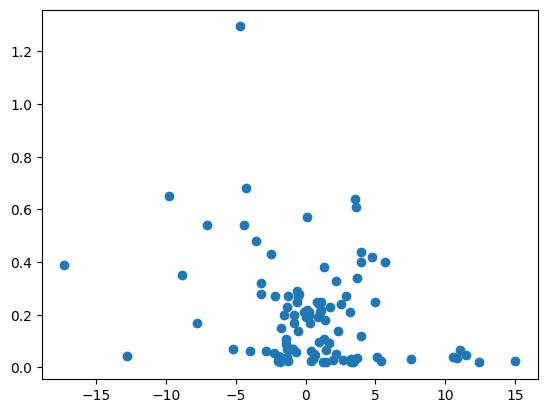

In [8]:
plt.scatter((np.array(open_nrg) - np.array(closed_nrg)), lpla_dat['Promiscuous Activity'])

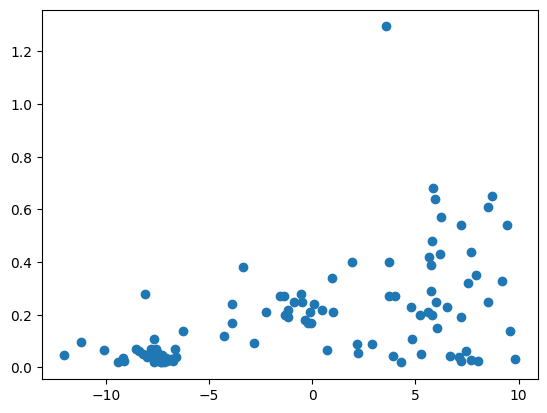

In [9]:
plt.scatter(lpla_dat['ProteinMPNN Open Score'] - lpla_dat['ProteinMPNN Closed Score'], lpla_dat['Promiscuous Activity'])

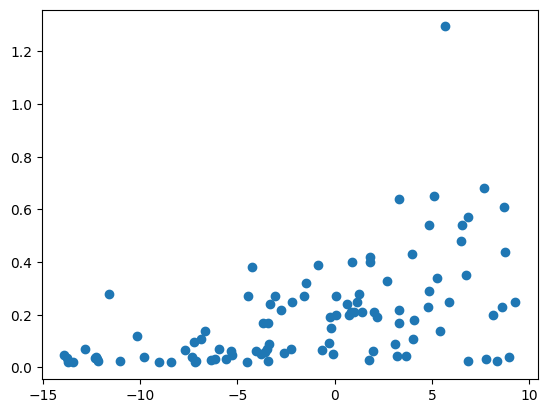

In [11]:
plt.scatter(lpla_dat['ESM IF Open Score'] - lpla_dat['ESMIF Closed Score'], lpla_dat['Promiscuous Activity'])

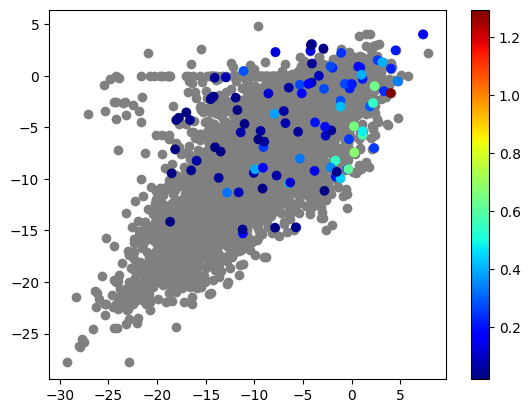

In [12]:
import matplotlib.pyplot as plt
plt.scatter(lpla_dat['ESM IF Open Score'], lpla_dat['ESMIF Closed Score'], color='grey')
plt.scatter(lpla_dat['ESM IF Open Score'], lpla_dat['ESMIF Closed Score'], c=lpla_dat['Promiscuous Activity'], cmap='jet')
plt.colorbar()

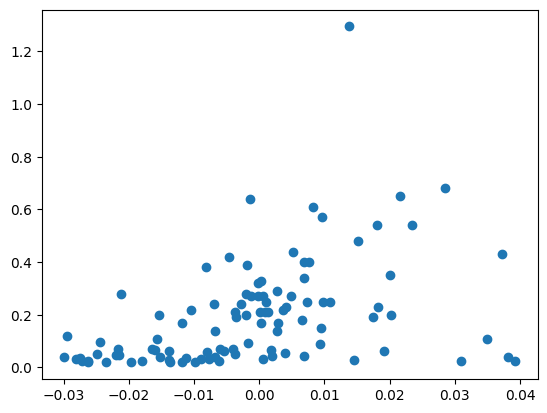

In [13]:
plt.scatter(lpla_dat['Frame2Seq Open Score'] - lpla_dat['Frame2Seq Closed Score'], lpla_dat['Promiscuous Activity'])

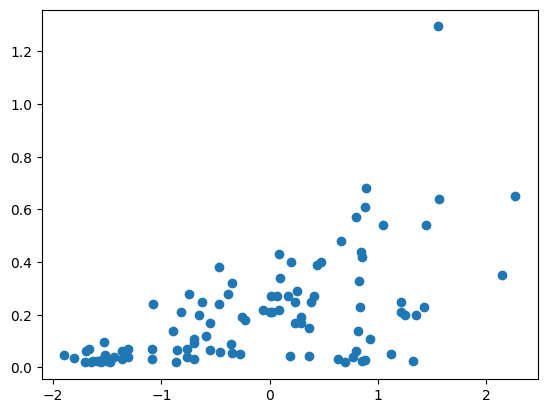

In [18]:
plt.scatter(lpla_dat['ThermoMPNN Open Score'] - lpla_dat['ThermoMPNN Closed Score'], lpla_dat['Promiscuous Activity'])